<a href="https://colab.research.google.com/github/shreya139/Circuits-in-Stocks/blob/202218061-JATAN/Final_Lstm_nifty_closing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
### Keras and Tensorflow >2.0

In [2]:
### Data Collection
import pandas_datareader as pdr
key=""

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
# from talib import RSI, BBANDS, MACD, EMA, STOCH, ADX
# from nsepy import get_history
from datetime import date
import yfinance as yf

In [249]:
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [387]:
yf.pdr_override() # <== that's all it takes :-)


#this is reference start date before EMA 200 days will fetch null
ref_startdate = date(2015,1,1)

#actual start date and end date from where the Nifty model to be built
startdate = date(2019,1,1)
enddate = date(2023,10,31)

# download dataframe
df = pdr.get_data_yahoo("^NSEI", start=startdate, end=enddate,interval='1d')
df


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,10868.849609,10895.349609,10735.049805,10792.500000,10792.500000,309700
2019-01-03,10796.799805,10814.049805,10661.250000,10672.250000,10672.250000,286200
2019-01-04,10699.700195,10741.049805,10628.650391,10727.349609,10727.349609,296600
2019-01-07,10804.849609,10835.950195,10750.150391,10771.799805,10771.799805,269400
2019-01-08,10786.250000,10818.450195,10733.250000,10802.150391,10802.150391,277700
...,...,...,...,...,...,...
2023-10-23,19521.599609,19556.849609,19257.849609,19281.750000,19281.750000,176000
2023-10-25,19286.449219,19347.300781,19074.150391,19122.150391,19122.150391,225300
2023-10-26,19027.250000,19041.699219,18837.849609,18857.250000,18857.250000,300400


In [388]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,10868.849609,10895.349609,10735.049805,10792.500000,10792.500000,309700
2019-01-03,10796.799805,10814.049805,10661.250000,10672.250000,10672.250000,286200
2019-01-04,10699.700195,10741.049805,10628.650391,10727.349609,10727.349609,296600
2019-01-07,10804.849609,10835.950195,10750.150391,10771.799805,10771.799805,269400
2019-01-08,10786.250000,10818.450195,10733.250000,10802.150391,10802.150391,277700


In [389]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-23,19521.599609,19556.849609,19257.849609,19281.750000,19281.750000,176000
2023-10-25,19286.449219,19347.300781,19074.150391,19122.150391,19122.150391,225300
2023-10-26,19027.250000,19041.699219,18837.849609,18857.250000,18857.250000,300400
2023-10-27,18928.750000,19076.150391,18926.650391,19047.250000,19047.250000,205200
2023-10-30,19053.400391,19158.500000,18940.000000,19140.900391,19140.900391,180100


In [390]:
df1=df.reset_index()['Close']

In [391]:
df1

0       10792.500000
1       10672.250000
2       10727.349609
3       10771.799805
4       10802.150391
            ...     
1186    19281.750000
1187    19122.150391
1188    18857.250000
1189    19047.250000
1190    19140.900391
Name: Close, Length: 1191, dtype: float64

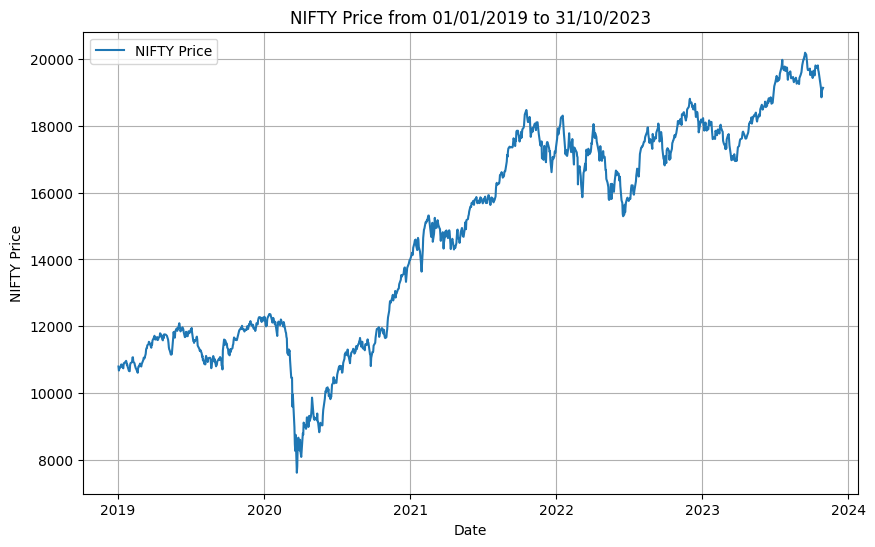

In [420]:
import matplotlib.pyplot as plt
# plt.plot(df1, label='NIFTY Price')
#  Price Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='NIFTY Price')
plt.xlabel('Date')
plt.ylabel('NIFTY Price')
plt.title('NIFTY Price from 01/01/2019 to 31/10/2023')
plt.legend()
plt.grid(True)
plt.show()

LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [393]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [394]:
# print(df1)

In [395]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [396]:
training_size,test_size

(952, 239)

In [397]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [398]:
# reshape into X=t,t+1,t+2,t+3,t+4------t+99 and Y=t+100
# In 1st row it contains 99 days closing price and in the target 100th day price
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [399]:
print(X_train.shape), print(y_train.shape)

(931, 20)
(931,)


(None, None)

In [400]:
print(X_test.shape), print(y_test.shape)

(218, 20)
(218,)


(None, None)

In [401]:
X_train

array([[0.25291884, 0.24336161, 0.24774081, ..., 0.25196906, 0.24251118,
        0.24176809],
       [0.24336161, 0.24774081, 0.25127363, ..., 0.24251118, 0.24176809,
        0.24173627],
       [0.24774081, 0.25127363, 0.25368583, ..., 0.24176809, 0.24173627,
        0.25597478],
       ...,
       [0.77128625, 0.76543266, 0.74497112, ..., 0.83234118, 0.82994489,
        0.83506734],
       [0.76543266, 0.74497112, 0.75610192, ..., 0.82994489, 0.83506734,
        0.84187466],
       [0.74497112, 0.75610192, 0.74741894, ..., 0.83506734, 0.84187466,
        0.8382345 ]])

In [402]:
y_train

array([0.24173627, 0.25597478, 0.26095807, 0.26243633, 0.26419276,
       0.27437394, 0.27492632, 0.26492793, 0.26057255, 0.25601056,
       0.24922707, 0.24750642, 0.24087396, 0.23796502, 0.24838463,
       0.25270819, 0.25285131, 0.25988108, 0.25632048, 0.25404348,
       0.25291884, 0.25856177, 0.26841309, 0.27362285, 0.27403615,
       0.27222407, 0.28276678, 0.29334931, 0.29656817, 0.29669134,
       0.30333567, 0.30614526, 0.31172463, 0.31082251, 0.30572405,
       0.2975656 , 0.30781826, 0.30478218, 0.31471298, 0.32259325,
       0.32609424, 0.32059039, 0.31693836, 0.3223389 , 0.31745497,
       0.32281577, 0.31584949, 0.31683505, 0.32055065, 0.32427812,
       0.33197165, 0.32924154, 0.31665623, 0.31518588, 0.32712349,
       0.32041948, 0.32938862, 0.32887201, 0.32701219, 0.32601872,
       0.31695823, 0.30898264, 0.2979789 , 0.29339696, 0.29157696,
       0.28118917, 0.28705859, 0.28188856, 0.28984428, 0.30177002,
       0.33523817, 0.32576833, 0.32805736, 0.32163152, 0.33649

In [403]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [404]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [405]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(20,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [406]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 20, 50)            10400     
                                                                 
 lstm_46 (LSTM)              (None, 20, 50)            20200     
                                                                 
 lstm_47 (LSTM)              (None, 50)                20200     
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [407]:
# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
24/24 [==============================] - 11s 210ms/step - loss: 0.0542 - val_loss: 0.0110
Epoch 2/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 3/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 6/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 8/10
24/24 [==============================] - 1s 35ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 9/10
24/24 [==============================] - 1s 34ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 10/10
24/24 [==============================] - 1s 35ms/step - loss: 0.0013 - val_loss: 0.0024


In [408]:
import tensorflow as tf

In [409]:

tf.__version__

'2.14.0'

In [410]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

7/7 [==============================] - 0s 10ms/step


In [411]:
# ##Transformback to original form
# train_predict=scaler.inverse_transform(train_predict)
# test_predict=scaler.inverse_transform(test_predict)

In [412]:
train_predict[:25]

array([[0.2640688 ],
       [0.263841  ],
       [0.26362914],
       [0.26328045],
       [0.26293454],
       [0.26269898],
       [0.2626636 ],
       [0.26301998],
       [0.26366   ],
       [0.26450717],
       [0.26511356],
       [0.26560536],
       [0.26587474],
       [0.26585117],
       [0.26540133],
       [0.2647684 ],
       [0.26413253],
       [0.26339346],
       [0.26281267],
       [0.26248977],
       [0.26223364],
       [0.2620218 ],
       [0.26162636],
       [0.26137125],
       [0.26141992]], dtype=float32)

In [413]:
y_train[:25]

array([0.24173627, 0.25597478, 0.26095807, 0.26243633, 0.26419276,
       0.27437394, 0.27492632, 0.26492793, 0.26057255, 0.25601056,
       0.24922707, 0.24750642, 0.24087396, 0.23796502, 0.24838463,
       0.25270819, 0.25285131, 0.25988108, 0.25632048, 0.25404348,
       0.25291884, 0.25856177, 0.26841309, 0.27362285, 0.27403615])

In [414]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.03956914478649876

In [415]:
# Calculate R2 score for training data
from sklearn.metrics import r2_score
r2 = r2_score(y_train, train_predict)
r2

0.9690375132629835

In [416]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

0.030601107566886006

In [417]:
#r2 score testing data
r2 = r2_score(y_test, test_predict)
r2

0.8074365151730474

In [418]:
# ##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

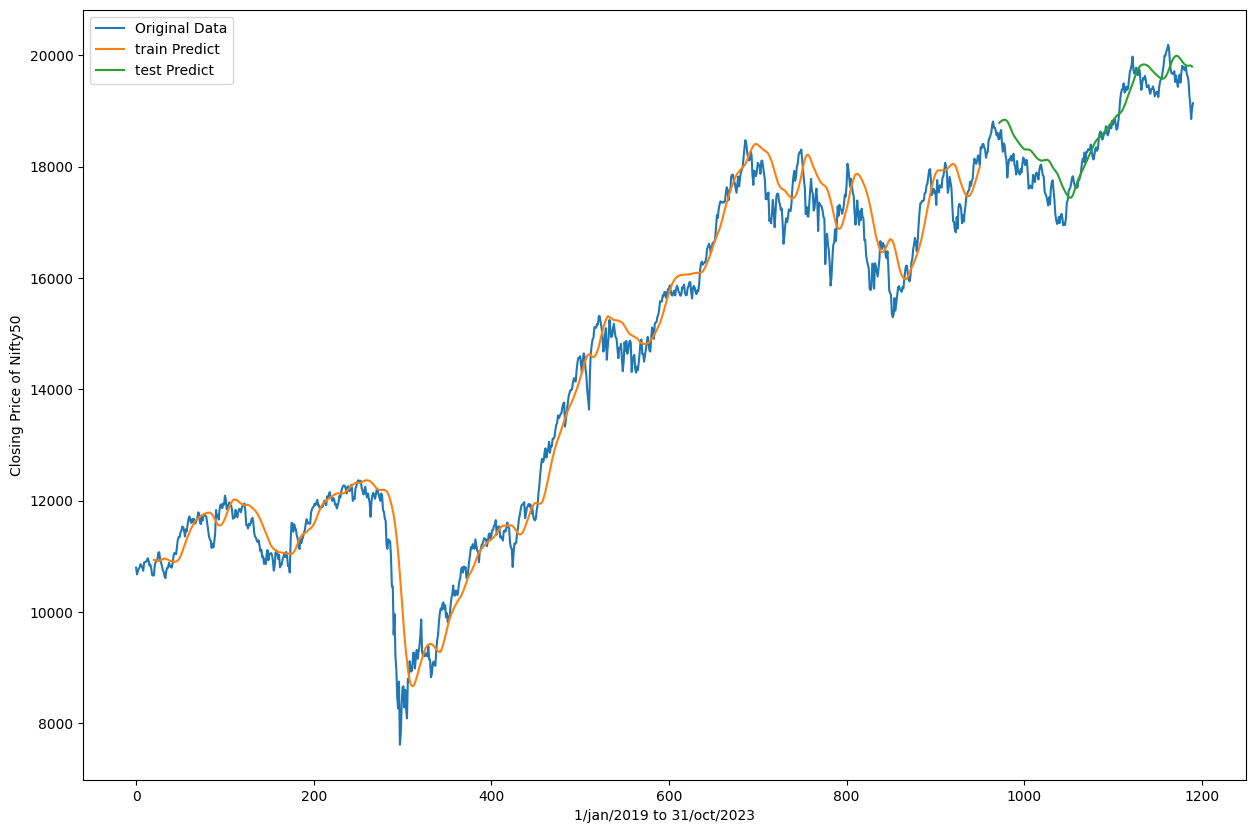

In [421]:
### Plotting
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(15, 10))
plt.plot(scaler.inverse_transform(df1), label='Original Data')
plt.plot(trainPredictPlot,label='train Predict')
plt.plot(testPredictPlot,label='test Predict')
# Add a legend to the plot
# Add labels
plt.xlabel("1/jan/2019 to 31/oct/2023")
plt.ylabel("Closing Price of Nifty50")
plt.legend()
plt.show()

#Observation

--> Decreasing timestamp(Lag variable) from 100 to 20 increased the r2 score.

--> Taking too much training data(2015 - 2023) gave the low  r2_score.

--> Taking very less training data(2022-2023) gave the very less r2_score(in minus).

--> So we have taken training data from 2019-2023.